In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim
from glob import glob
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2

In [3]:
folderpath = "/content/drive/MyDrive/Colab Notebooks/2023/Performance Comparison"
datapath = f"{folderpath}/data"

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [5]:
label_list = ['Butterfly', 'Cat', 'Chicken', 'Cow', 'Dog', 'Elephant', 'Horse', 'Sheep', 'Spider', 'Squirrel']

In [6]:
class DataProcess():
    def __init__(self, dataType='train'):
        self.dataType = dataType
        self.imgPathList = []
        self.imgCountList = []
        self.totalCount = 0

        for label in label_list:
            image_path = f"{datapath}/{label}"
            image_list = glob(f"{image_path}/*.jpg")
            _len = len(image_list)
            print(label, _len)

            if dataType =='train':
                image_list = image_list[:int(_len * 0.8)]
            elif dataType == 'valid':
                image_list = image_list[int(_len * 0.8):] 

            self.imgPathList.append(image_list)
            count = len(image_list)
            self.imgCountList.append(count)
            self.totalCount += count

    def findImagePath(self, idx):
        label_idx = 0
        for (i, count) in enumerate(self.imgCountList):
            label_idx = i
            if idx < count:
                path = self.imgPathList[i][idx]
                return path, label_idx
            idx -= count
        return self.imgPathList[-1][idx], label_idx

    def getLength(self):
        return self.totalCount
     

In [7]:
train_dataprocess = DataProcess(dataType='train')
valid_dataprocess = DataProcess(dataType='valid')
# test_dataprocess = DataProcess(dataType='test')

Butterfly 422
Cat 440
Chicken 0
Cow 0
Dog 0
Elephant 359
Horse 0
Sheep 376
Spider 322
Squirrel 0
Butterfly 422
Cat 440
Chicken 0
Cow 0
Dog 0
Elephant 359
Horse 0
Sheep 376
Spider 322
Squirrel 0


In [8]:
print(train_dataprocess.getLength(), valid_dataprocess.getLength())

1533 386


In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, mode='train', transforms=None):
        self.transforms = transforms
        self.mode = mode
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            path, label = train_dataprocess.findImagePath(idx)
        elif self.mode == 'valid':
            path, label = valid_dataprocess.findImagePath(idx)
        elif self.mode == 'test':
            path, label = test_dataprocess.findImagePath(idx)
        else:
            print('Invalid Mode')
            assert(0)
        image = Image.open(path)
        image = image.convert("RGB")
        if self.transforms is not None:
            image = self.transforms(image)
            
        return (image, label)

    def __len__(self):
        if self.mode == 'train':
            return train_dataprocess.getLength()
        elif self.mode == 'valid':
            return valid_dataprocess.getLength()
        return test_dataprocess.getLength()

In [10]:
transforms = torchvision.transforms.Compose([
                  torchvision.transforms.Resize((224, 224)),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
train_dataset = CustomDataset(mode='train', transforms=transforms)
valid_dataset = CustomDataset(mode='valid', transforms=transforms)
# test_dataset = CustomDataset(mode='test', transforms=transforms)

In [12]:
image, label = train_dataset[100]
print(image.shape)

torch.Size([3, 224, 224])


In [13]:
import torchvision.transforms as T

tf = T.ToPILImage()

image = tf(image)

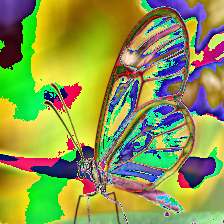

In [14]:
image

In [15]:
label

0

In [16]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [17]:
num_classes = 10

resnet_model = torchvision.models.resnet101(pretrained=True)
num_output = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_output, 1024, bias=True)
resnet_model = nn.Sequential(
    resnet_model,
    nn.Linear(1024, 512),
    nn.Dropout(),
    nn.Linear(512, 256),
    nn.Dropout(),
    nn.Linear(256, 10)
)
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [18]:
resnet_model.train()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [19]:
learning_rate = 0.001
num_epochs = 1000

resnet_optimizer = torch.optim.SGD(resnet_model.parameters(), lr=learning_rate)
resnet_scheduler = optim.lr_scheduler.LambdaLR(optimizer=resnet_optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

modelpath = f"{folderpath}/model/ResNet101"

In [20]:
import os.path

if os.path.exists(f"{modelpath}/model_state_dict.pt"):
    resnet_model.load_state_dict(torch.load(f"{modelpath}/model_state_dict.pt"))
    resnet_optimizer.load_state_dict(torch.load(f"{modelpath}/optim_state_dict.pt"))
    resnet_scheduler.load_state_dict(torch.load(f"{modelpath}/scheduler_state_dict.pt"))
    print('Load Complete')
else:
    print('Load Fail')

Load Complete


In [21]:
def getAverage(l):
    return sum(l) / len(l)

In [22]:
print(next(resnet_model.parameters()).is_cuda)

True


In [23]:
f = open(f"{folderpath}/log/CNN.txt", 'w')

In [24]:
import time

start = time.time()
error = nn.MSELoss()
resnet_model.train()
count = 0
globalMinLoss = float('inf')
print("-------Running-------")
for epoch in range(num_epochs):
    train_loss_list, valid_loss_list = [], []

    for (images, labels) in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        resnet_optimizer.zero_grad()
        outputs = resnet_model(images.view(batch_size, 3, 224, 224))
        outputs = torch.max(outputs, 1)[1]
 
        outputs = outputs.to(torch.float32)
        labels = labels.to(torch.float32)
        # print(outputs, labels)
        loss = error(outputs, labels)
        loss.requires_grad = True
        loss.backward()
        resnet_optimizer.step()
        train_loss_list.append(loss)
        count += 1
    resnet_scheduler.step()
    if epoch % 1 == 0:
        with torch.no_grad():
            for (images ,labels) in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = resnet_model(images.view(batch_size, 3, 224, 224))
                outputs = torch.max(outputs, 1)[1]
                outputs = outputs.to(torch.float32)
                labels = labels.to(torch.float32)
                loss = error(outputs, labels)
                valid_loss_list.append(loss)

            train_loss = getAverage(train_loss_list)
            valid_loss = getAverage(valid_loss_list)
            epoch_log = f"""{time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())} || [{epoch}/{num_epochs}], train_loss = {train_loss:.4f}, valid_loss = {valid_loss:.4f}"""
            print(epoch_log)
            f.write(epoch_log)
            f.write('\n')
            if valid_loss < globalMinLoss:
                globalMinLoss = valid_loss
                best_model_state = resnet_model.state_dict()
                best_optim_state = resnet_optimizer.state_dict()
                best_scheduler_state = resnet_scheduler.state_dict()
elapsed = time.time() - start
print(f"End of training, elapsed time : {elapsed // 60} min {elapsed % 60} sec.")
     

-------Running-------
2023-02-05 06:27:40 || [0/1000], train_loss = 19.8159, valid_loss = 19.5000
2023-02-05 06:28:48 || [1/1000], train_loss = 19.1467, valid_loss = 16.9349
2023-02-05 06:29:21 || [2/1000], train_loss = 19.7541, valid_loss = 19.1901
2023-02-05 06:29:51 || [3/1000], train_loss = 19.7819, valid_loss = 19.3021
2023-02-05 06:30:22 || [4/1000], train_loss = 19.2806, valid_loss = 19.3516
2023-02-05 06:30:52 || [5/1000], train_loss = 18.5516, valid_loss = 20.1250
2023-02-05 06:31:22 || [6/1000], train_loss = 19.2507, valid_loss = 19.5104
2023-02-05 06:31:52 || [7/1000], train_loss = 17.7228, valid_loss = 17.8125
2023-02-05 06:32:22 || [8/1000], train_loss = 19.0034, valid_loss = 19.8906
2023-02-05 06:32:53 || [9/1000], train_loss = 19.1413, valid_loss = 18.9922
2023-02-05 06:33:23 || [10/1000], train_loss = 19.1549, valid_loss = 18.0052
2023-02-05 06:33:53 || [11/1000], train_loss = 19.4837, valid_loss = 18.8411
2023-02-05 06:34:24 || [12/1000], train_loss = 19.1827, valid_lo

KeyboardInterrupt: ignored

In [25]:
f.close()

In [26]:
modelpath = f"{folderpath}/model/ResNet101"

f"{modelpath}/model_state_dict.pt"

if best_model_state is not None and best_optim_state is not None:
    torch.save(best_model_state, f"{modelpath}/model_state_dict.pt")
    torch.save(best_optim_state, f"{modelpath}/optim_state_dict.pt")
    torch.save(best_scheduler_state, f"{modelpath}/scheduler_state_dict.pt")
    print("Successfully saved.")

Successfully saved.


In [ ]:
resnet_model.eval()

In [ ]:
for (images, labels) in test_loader:
    images = images.to(device)
    outputs = resnet_model(images.view(batch_size, 3, 224, 224))
    outputs = torch.max(outputs, 1)[1]
    print(zip(outputs, labels))
    assert(0)
  

In [ ]:
outputs[:10]

In [ ]:
labels[:10]

In [ ]:
 for (images ,labels) in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = resnet_model(images.view(batch_size, 3, 224, 224))
                outputs = torch.max(outputs, 1)[1]
                outputs = outputs.to(torch.float32)
                labels = labels.to(torch.float32)
                loss = error(outputs, labels)
                valid_loss_list.append(loss)

            train_loss = getAverage(train_loss_list)
            valid_loss = getAverage(valid_loss_list)